# Movie Classification Team 11

# EDA and Plot Transformations

### Team Members:
Andrew Lund, Nicholas Morgam, Amay Umradia, Charles Webb

**The purpose of this notebook is two-fold:**
1. To explore the dataset we have built with TMDB and IMDB movie data on 1000 movies. We will primarily be exploring plot and genre information since that is the primary focus of this project: Predicting genres from plots. 
2. To apply bag-of-words with TFIDF and word2vec plot transformations of the TMDB, IMDB, and combined plots.

In [2]:
#import libraries and set seaborn styling
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tmdbsimple as tmdb
import requests
import pandas as pd
import time
import numpy as np
from ast import literal_eval
from collections import Counter
from nltk.tokenize import RegexpTokenizer
from stop_words import get_stop_words
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim import models
sns.set_context('talk')
sns.set_style('ticks')

C:\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


---
# EDA
#### GET TMDB genre labels for reference

We will be using the TMDB genres as our response variable throughout this project. The analysis for these plots can be found in our Milestone 3 and Final Report documents located in this repository's 'submissions' directory.

In [4]:
key = open('key.txt','r').read()
payload = '{}'
url = "https://api.themoviedb.org/3/genre/movie/list?api_key={0}&language=en-US&page={1}".format(key, str(1))
response = requests.request("GET", url, data=payload).json()

genreDict = dict(zip([i['id'] for i in response['genres']],
                     [i['name'] for i in response['genres']]))
genreDict

{12: 'Adventure',
 14: 'Fantasy',
 16: 'Animation',
 18: 'Drama',
 27: 'Horror',
 28: 'Action',
 35: 'Comedy',
 36: 'History',
 37: 'Western',
 53: 'Thriller',
 80: 'Crime',
 99: 'Documentary',
 878: 'Science Fiction',
 9648: 'Mystery',
 10402: 'Music',
 10749: 'Romance',
 10751: 'Family',
 10752: 'War',
 10770: 'TV Movie'}

#### Read in our scraped movie data

The "movies" dataframe below includes some of the plot transformations further along in this notebook since we have manipulated and saved our scraped data multiple times throoughout the duration of this project.

In [5]:
#list of columns in our 'movies.csv' that need to be read in using literal_eval
#to ensure they are represented as vectors rather than strings
converterList = ['imdb_genres', 'tmdb_genres', 'binary_tmdb', 'binary_imdb',
               'imdb_w2v_plot', 'tmdb_w2v_plot']

converterDict = {column: literal_eval for column in converterList}

movies = pd.read_csv('data/movies.csv', encoding='utf-8',
                     converters=converterDict)

movies.release_date = pd.to_datetime(movies.release_date)
movies.head()

,tmdb_id,imdb_id,tmdb_genres,imdb_genres,binary_tmdb,binary_imdb,tmdb_plot,imdb_plot,popularity,release_date,...,imdb_bow_plot,combined_plots,combined_bow_plots,combined_clean_plot,tmdb_w2v_plot_mean,imdb_w2v_plot_mean,combined_w2v_plot_mean,tmdb_w2v_plot_matrix,imdb_w2v_plot_matrix,combined_w2v_plot_matrix
0,278,tt0111161,"[18, 80]","[80, 18]","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...",Framed in the 1940s for the double murder of h...,Chronicles the experiences of a formerly succe...,28.527767,1994-09-23,...,"(0, 398)\t0.22753905256972778\n (0, 759)\t0...",Framed in the 1940s for the double murder of h...,"(0, 1092)\t0.15089615016031976\n (0, 811)\t...","['framed', '1940s', 'double', 'murder', 'wife'...",[ 1.41657051e-02 3.57291475e-02 3.55668515e-...,[ 4.66356799e-03 9.01858658e-02 -1.24760680e-...,[ 0.00908005 0.064875 0.00985374 0.060550...,[[-0.08300781 0.25390625 0.07128906 ... -0.1...,[[ 0.0201416 0.11474609 -0.35742188 ... -0.0...,[[-0.08300781 0.25390625 0.07128906 ... -0.1...
1,238,tt0068646,"[18, 80]","[80, 18]","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...",Spanning the years 1945 to 1955 a chronicle o...,When the aging head of a famous crime family d...,36.965452,1972-03-14,...,"(0, 515)\t0.17259715509464205\n (0, 938)\t0...",Spanning the years 1945 to 1955 a chronicle o...,"(0, 1773)\t0.10485484905546055\n (0, 287)\t...","['spanning', 'years', '1945', '1955', 'chronic...",[-0.01682084 0.05966978 -0.00681898 0.042978...,[-0.01332631 0.0813482 0.03576481 0.067564...,[-1.48730669e-02 7.17528313e-02 1.69162434e-...,[[ 0.05175781 0.02502441 -0.12255859 ... 0.0...,[[-0.07470703 0.49804688 -0.07373047 ... 0.2...,[[ 0.05175781 0.02502441 -0.12255859 ... 0.0...
2,424,tt0108052,"[18, 36, 10752]","[18, 36]","[0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...",The true story of how businessman Oskar Schind...,Oskar Schindler is a vainglorious and greedy G...,19.945455,1993-11-29,...,"(0, 916)\t0.40896979889639457\n (0, 317)\t0...",The true story of how businessman Oskar Schind...,"(0, 2911)\t0.09695795170181548\n (0, 2774)\...","['true', 'story', 'businessman', 'oskar', 'sch...",[ 0.07589068 0.02254813 0.0643049 0.117789...,[ 0.05338115 0.10281134 0.01086032 0.044059...,[ 6.03841133e-02 7.78405592e-02 2.74875220e-...,[[ 1.27929688e-01 4.78515625e-02 1.06933594e...,[[ 0.06542969 0.06054688 0.00114441 ... -0.0...,[[ 0.12792969 0.04785156 0.10693359 ... 0.0...
3,240,tt0071562,"[18, 80]","[80, 18]","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...",In the continuing saga of the Corleone crime f...,The continuing saga of the Corleone crime fami...,30.191804,1974-12-20,...,"(0, 515)\t0.21968270215051702\n (0, 1494)\t...",In the continuing saga of the Corleone crime f...,"(0, 1821)\t0.12839540573874353\n (0, 649)\t...","['continuing', 'saga', 'corleone', 'crime', 'f...",[-5.79080023e-02 7.11167306e-02 -6.58677071e-...,[-5.15192188e-02 7.89628476e-02 -4.06892076e-...,[-5.43040745e-02 7.55427405e-02 -5.16644493e-...,[[-0.0324707 0.21679688 -0.1484375 ... 0.2...,[[-0.0324707 0.21679688 -0.1484375 ... 0.2...,[[-0.0324707 0.21679688 -0.1484375 ... 0.2...
4,452522,tt0278784,"[18, 9648]","[80, 18, 9648, 53]","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, ...",Standalone version of the series pilot with an...,When beautiful young Laura Palmer is found br...,5.969249,1989-12-31,...,"(0, 875)\t0.15459130001922888\n (0, 2438)\t...",Standalone version of the series pilot with an...,"(0, 1088)\t0.12464518166470029\n (0, 2380)\...","['standalone', 'version', 'series', 'pilot', '...",[-0.05888228 -0.0534557 -0.06566273 0.057356...,[ 2.65587703e-03 1.01409487e-01 1.30335495e-...,[-1.17466701e-02 6.51644468e-02 -1.52680418e-...,[[ 0.01477051 -0.33203125 -0.37109375 ... -0.0...,[[

#### Print a movie title and its TMDB and IMDB plot for comparison

In [6]:
print('Title:\n', movies.title[12],
      '\n\nTMDB Plot:\n', movies.tmdb_plot[12], 
      '\n\nIMDB Plot:\n', movies.imdb_plot[12])

Title:
 Psycho 

TMDB Plot:
 When larcenous real estate clerk Marion Crane goes on the lam with a wad of cash and hopes of starting a new life  she ends up at the notorious Bates Motel  where manager Norman Bates cares for his housebound mother  The place seems quirky  but fine  until Marion decides to take a shower 

IMDB Plot:
 Phoenix officeworker Marion Crane is fed up with the way life has treated her  She has to meet her lover Sam in lunch breaks and they cannot get married because Sam has to give most of his money away in alimony  One Friday Marion is trusted to bank  40 000 by her employer  Seeing the opportunity to take the money and start a new life  Marion leaves town and heads towards Sam s California store  Tired after the long drive and caught in a storm  she gets off the main highway and pulls into The Bates Motel  The motel is managed by a quiet young man called Norman who seems to be dominated by his mother   Col Needham 


### Distribution of Movie Ratings in Dataset

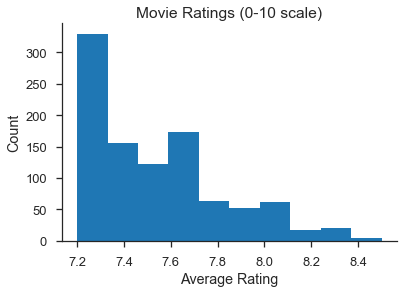

In [7]:
plt.hist(movies.vote_average)
plt.title('Movie Ratings (0-10 scale)')
plt.xlabel('Average Rating')
plt.ylabel('Count')
sns.despine()

### Total Counts of TMDB Genres in Dataset

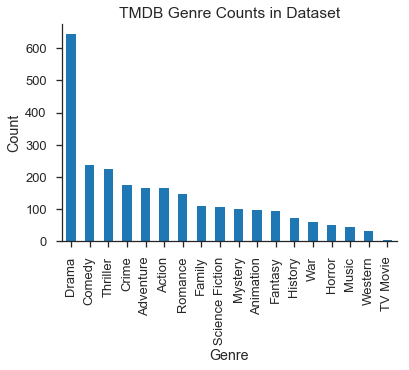

In [8]:
genre_list_ints = []
for sublist in list(movies.tmdb_genres):
    for item in sublist:
        genre_list_ints.append(item)

genre_list_strings = []
for genre in genre_list_ints:
    genre_list_strings.append(genreDict[genre])
    
genre_counts = Counter(genre_list_strings)
genre_df = pd.DataFrame.from_dict(genre_counts, orient='index')
genre_df.sort_values(by = 0, ascending=False).plot(kind='bar', legend=False)
plt.title('TMDB Genre Counts in Dataset')
plt.ylabel('Count')
plt.xlabel('Genre')
sns.despine()

### Count by Movie of Total TMDB & IMDB Genre Labels in Dataset

Average TMDB Genres: 2.535
Average IMDB Genres: 2.831


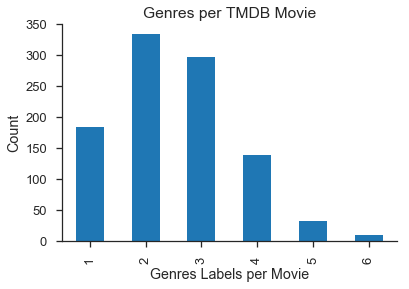

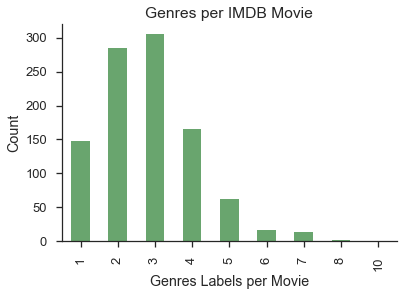

In [9]:
#count number of genres per movie
tmdb_num_genres_per_movie = [len(genres) for genres in movies.tmdb_genres]
imdb_num_genres_per_movie = [len(genres) for genres in movies.imdb_genres]

#collect counts and plot for both imdb and tmdb
tmdb_num_genre_counts = Counter(tmdb_num_genres_per_movie)
tmdb_genre_counts_df = pd.DataFrame.from_dict(tmdb_num_genre_counts, orient='index')
tmdb_genre_counts_df = tmdb_genre_counts_df.sort_index()
tmdb_genre_counts_df.plot(kind='bar', legend=False)
plt.title('Genres per TMDB Movie')
plt.xlabel('Genres Labels per Movie')
plt.ylabel('Count')
sns.despine()


imdb_num_genre_counts = Counter(imdb_num_genres_per_movie)
imdb_genre_counts_df = pd.DataFrame.from_dict(imdb_num_genre_counts, orient='index')
imdb_genre_counts_df = imdb_genre_counts_df.sort_index()
imdb_genre_counts_df.plot(kind='bar', legend=False, color='#69a56e')
plt.title('Genres per IMDB Movie')
plt.xlabel('Genres Labels per Movie')
plt.ylabel('Count')
sns.despine()

print('Average TMDB Genres:', np.mean(tmdb_num_genres_per_movie))
print('Average IMDB Genres:', np.mean(imdb_num_genres_per_movie))

### Counts of Movie Release Years in Dataset

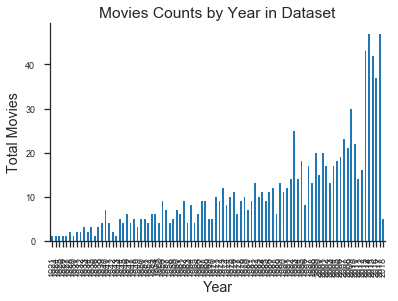

In [10]:
movie_years = [year.year for year in movies.release_date]
year_counts = Counter(movie_years)
year_df = pd.DataFrame.from_dict(year_counts, orient='index')
year_df.sort_index().plot(kind='bar', legend=False)
plt.title('Movies Counts by Year in Dataset')
plt.tick_params(labelsize=9)
plt.ylabel('Total Movies')
plt.xlabel('Year')
sns.despine()

### Distribution of TMDB & IMDB Plot Lengths

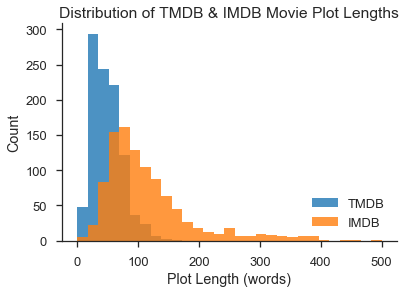

In [11]:
#tmdb lengths
tmdb_plot_lengths = []
for plot in movies.tmdb_plot:
    plot_length = len(plot.split())
    tmdb_plot_lengths.append(plot_length)
    
#imdb lengths
imdb_plot_lengths = []
for plot in movies.imdb_plot:
    plot_length = len(plot.split())
    imdb_plot_lengths.append(plot_length)
    
#plot tmdb lengths
bins = np.linspace(0, 500, 30)
plt.hist(tmdb_plot_lengths, bins, alpha = 0.8, label = 'TMDB')
plt.hist(imdb_plot_lengths, bins, alpha = 0.8, label = 'IMDB')
plt.xlabel('Plot Length (words)')
plt.ylabel('Count')
plt.title('Distribution of TMDB & IMDB Movie Plot Lengths')
plt.legend(loc='lower right')
sns.despine();

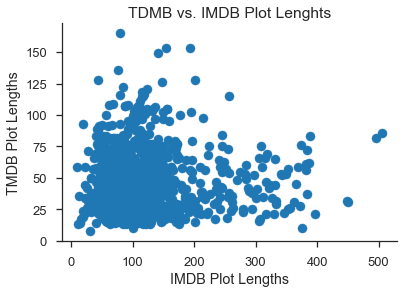

In [12]:
#scatter of TMDB vs IMDB plot lengths
plt.scatter(imdb_plot_lengths, tmdb_plot_lengths)
plt.title('TDMB vs. IMDB Plot Lenghts')
plt.xlabel('IMDB Plot Lengths')
plt.ylabel('TMDB Plot Lengths')
sns.despine();

#### More plot length metrics

In [13]:
print('Shortest and longest plots (words):')
print('TMDB: ', min(tmdb_plot_lengths),',', max(tmdb_plot_lengths))
print('Mean TMDB plot length:', np.mean(tmdb_plot_lengths))
print()
print('IMDB: ', min(imdb_plot_lengths),',', max(imdb_plot_lengths))
print('Mean IMDB plot length:', np.mean(imdb_plot_lengths))


Shortest and longest plots (words):
TMDB:  8 , 165
Mean TMDB plot length: 48.663

IMDB:  10 , 505
Mean IMDB plot length: 115.771


### Plot Lengths vs. Number of Genres per Movie

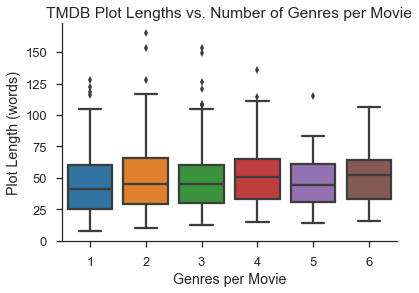

In [14]:
sns.boxplot(tmdb_num_genres_per_movie, tmdb_plot_lengths)
plt.title('TMDB Plot Lengths vs. Number of Genres per Movie')
plt.xlabel('Genres per Movie')
plt.ylabel('Plot Length (words)')
sns.despine()

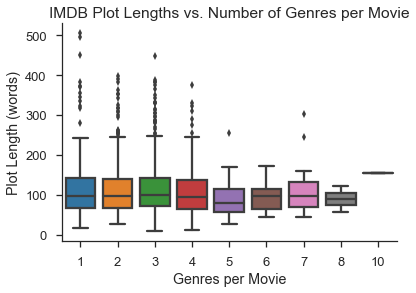

In [15]:
sns.boxplot(imdb_num_genres_per_movie, imdb_plot_lengths)
plt.title('IMDB Plot Lengths vs. Number of Genres per Movie')
plt.xlabel('Genres per Movie')
plt.ylabel('Plot Length (words)')
sns.despine()

---
# Bag-of-words transformations of our TMDB, IMDB, and combined movie plots


### Make a new feature of combined TMDB and IMDB plots
We will make a new column with the combined plots of tmdb and imdb. Perhaps this will offer a richer representation of each plot and increase our precision and recall in the forthcoming modeling.

In [16]:
movies['combined_plots'] = movies['tmdb_plot'] + ' ' + movies['imdb_plot']

---
### Apply Count Vectorize and TFIDF to Plots

Sklearn's TfidfVectorizer will apply both a count vectorizer and Term Frequency Inverse Document Frequency (TFIDF) transformation to our plots. The count vectorizer will convert our collection of plots into a matrix of word counts. We set max_df and min_df to ignore words specific to our corpus of movie plots that occur both a lot and few times, and we also ignore english stop words if the previous arguments missed some. The TFIDF transformation will essentially apply a rarity score to each word returning a normalized TFIDF matrix for each feature - TMDB, IMDB, and combined plots.

In [17]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=0.005, 
                          stop_words = get_stop_words('en'))

tmdb_bow=tfidf_vectorizer.fit_transform(movies['tmdb_plot'])
imdb_bow=tfidf_vectorizer.fit_transform(movies['imdb_plot'])
combined_bow = tfidf_vectorizer.fit_transform(movies['combined_plots'])

#check shape of resulting matrices
tmdb_bow.shape, imdb_bow.shape, combined_bow.shape

((1000, 1171), (1000, 2442), (1000, 3025))

As seen above, now each TMDB and IMDB movies are represented by an 1171 and 2439 length array, and each combined plot is a 3025 length array, respectively. Each number in the array is the associated TFIDF score for the count vectorized representation of each plot. Most of the array values will be zero since each movie has on average 50 and 100 words for TMDB and IMDB, respectively.

---

### Add Bag-of-Words Matrices to Movies DF and save

We cast the resulting arrays into lists that pandas can save in a nice fashion for when we import in the modeling and analysis notebook. We also save them as numpy arrays for easier importing.

In [18]:
#each plot is a row vector of the TFIDF sparse matrices
movies['tmdb_bow_plot'] = [plot for plot in tmdb_bow]
movies['imdb_bow_plot'] = [plot for plot in imdb_bow]
movies['combined_bow_plots'] = [plot for plot in combined_bow]

#resave movies csv
movies.to_csv('data/movies.csv', encoding="utf-8", index=False)

#save TFIDF matrices an numpy arrays
np.save('data/tmdb_bow.npy',tmdb_bow.toarray())
np.save('data/imdb_bow.npy',imdb_bow.toarray())
np.save('data/combined_bow.npy', combined_bow.toarray())

### We have now transformed and saved each plot as a bag-of-words TFIDF representation.
---
# Word2vec transformation of our TMDB, IMDB, and combined movie plots
---
#### Clean plots

In [19]:
#define tokenizer
tokenizer = RegexpTokenizer(r'\w+')
#set stop words list
english_stop = get_stop_words('en')
print(len(english_stop))

#function to clean plots
def clean_plot(plot):
    '''
    clean_plot()
    -applies the following the plot of a movie:
        1) lowers all strings
        2) tokenizes each word
        3) removed English stop words

    -inputs: plot (string)
    
    -outputs: list representation of plot
    '''
    plot = plot.lower()
    plot = tokenizer.tokenize(plot)
    plot = [word for word in plot if word not in english_stop]
    return plot

174


In [20]:
#check function on first movie's clean plot
print(movies.tmdb_plot[0])
print(clean_plot(movies.tmdb_plot[0]))

Framed in the 1940s for the double murder of his wife and her lover  upstanding banker Andy Dufresne begins a new life at the Shawshank prison  where he puts his accounting skills to work for an amoral warden  During his long stretch in prison  Dufresne comes to be admired by the other inmates    including an older prisoner named Red    for his integrity and unquenchable sense of hope
['framed', '1940s', 'double', 'murder', 'wife', 'lover', 'upstanding', 'banker', 'andy', 'dufresne', 'begins', 'new', 'life', 'shawshank', 'prison', 'puts', 'accounting', 'skills', 'work', 'amoral', 'warden', 'long', 'stretch', 'prison', 'dufresne', 'comes', 'admired', 'inmates', 'including', 'older', 'prisoner', 'named', 'red', 'integrity', 'unquenchable', 'sense', 'hope']


---
#### Apply clean_plots() function to TMDB, IMDB, and combined plots

In [21]:
#apply to movies df for both imdb and tmdb
movies['tmdb_clean_plot'] = movies['tmdb_plot'].apply(lambda x: clean_plot(x))
movies['imdb_clean_plot'] = movies['imdb_plot'].apply(lambda x: clean_plot(x))
movies['combined_clean_plot'] = movies['combined_plots'].apply(lambda x: clean_plot(x))

#check some outputs
movies.tmdb_clean_plot[1:5], movies.imdb_clean_plot[1:5], movies.combined_clean_plot[1:5]

(1    [spanning, years, 1945, 1955, chronicle, ficti...
 2    [true, story, businessman, oskar, schindler, s...
 3    [continuing, saga, corleone, crime, family, yo...
 4    [standalone, version, series, pilot, alternate...
 Name: tmdb_clean_plot, dtype: object,
 1    [aging, head, famous, crime, family, decides, ...
 2    [oskar, schindler, vainglorious, greedy, germa...
 3    [continuing, saga, corleone, crime, family, te...
 4    [beautiful, young, laura, palmer, found, bruta...
 Name: imdb_clean_plot, dtype: object,
 1    [spanning, years, 1945, 1955, chronicle, ficti...
 2    [true, story, businessman, oskar, schindler, s...
 3    [continuing, saga, corleone, crime, family, yo...
 4    [standalone, version, series, pilot, alternate...
 Name: combined_clean_plot, dtype: object)

---
#### Apply word2vec Transformation of Plots

For this transformation we will use the Google News pretrained word2vec model that was trained on a more than 3 billion word corpus. It contains 3 million words, each represented by a 300-dimension vector. We make a couple of design choices for how we transform our movie plots:

- If a word in the cleaned plots (lowered, punctuation and stop word dropped, tokenized) is in the word2vec model, add it to a running list for that plot.
- If a word is not in the word2vec model, skip it. We print some of these words below for example.
- We then take two different representations for each plot. One as a matrix where each row is a 300-dimension representation of a particular word in the plot, and a column-wise mean vector, where each plot is reduced to 1x300 dimension array.

The assumption we make by taking the mean of each plot is that the resulting 300-dimension vector will point in the direction of one or more genres, but we acknowledge that it will most likely reduce some of the semantic value of certain words.


In [34]:
#Load the pretrained google news word2vec model
model = models.KeyedVectors.load_word2vec_format('data/word2vec-GoogleNews-vectors-master/GoogleNews-vectors-negative300.bin', binary=True)

In [35]:
#collect words not in the Google News w2v model
not_w2v = []

#word2vec function
def apply_words2Vec(cleaned_plot, mean=False):
    
    """
    apply_words2Vec()
    -applies the following transformations to the cleaned plot of a movie:
        1) removes words that are not in google's model
        2) creates a 300-dimension vector representation of each word
        3) outputes vector of vectors for plot
        If mean = True
        4) converts the resulting nd_array into a 1d_array via np.mean() and
           outputs single vector for each plot.
    -also keeps track of all words not found in google's model
    
    -inputs: cleaned_plot (string)
    
    -outputs: vector representation of plot
    
    """
    vecs=[]
    for word in cleaned_plot:
        #add word vector to list if it is in the google model
        try:
            vecs.append(model.word_vec(word)) 
        except:
            #if the word is not in the w2v model, add it to
            #our list of skipped words
            not_w2v.append(word)
    
    #take the column-wise mean of vecs to reduce nd_aray to 1d_array
    if mean == True:
        vecs = np.mean(vecs, axis=0)
        return vecs
    #return matrix of w2v arrays where each row is a word in the plot
    return np.stack(vecs)

In [36]:
#apply transformation to three sets of plots and add columns to df

#columns with mean w2v
movies['tmdb_w2v_plot_mean'] = movies['tmdb_clean_plot'].apply(lambda x: apply_words2Vec(x, mean=True))
movies['imdb_w2v_plot_mean'] = movies['imdb_clean_plot'].apply(lambda x: apply_words2Vec(x, mean=True))
movies['combined_w2v_plot_mean'] = movies['combined_clean_plot'].apply(lambda x: apply_words2Vec(x, mean=True))

#columns with w2v matrix for each plot
movies['tmdb_w2v_plot_matrix'] = movies['tmdb_clean_plot'].apply(lambda x: apply_words2Vec(x, mean=False))
movies['imdb_w2v_plot_matrix'] = movies['imdb_clean_plot'].apply(lambda x: apply_words2Vec(x, mean=False))
movies['combined_w2v_plot_matrix'] = movies['combined_clean_plot'].apply(lambda x: apply_words2Vec(x, mean=False))

#check shapes of first movie vectors to confirm nd_array and 300-dimensions
print('Mean vector representations:')
print(movies.loc[0,'tmdb_w2v_plot_mean'].shape, 
      movies.loc[0,'imdb_w2v_plot_mean'].shape, 
      movies.loc[0, 'combined_w2v_plot_mean'].shape)

print('Matrix representations:')
print(movies.loc[0,'tmdb_w2v_plot_matrix'].shape, 
      movies.loc[0,'imdb_w2v_plot_matrix'].shape,
      movies.loc[0,'combined_w2v_plot_matrix'].shape)

Mean vector representations:
(300,) (300,) (300,)
Matrix representations:
(33, 300) (38, 300) (71, 300)


Each TMDB and IMDB plot has been transformed into a 300-dimension representation of that plot, as well as an matrix where each row represents a word in the plot. We will use these features as predictors in our multi-lable classification modeling.

In [37]:
#print some of our skipped words
print(len(not_w2v))
np.random.seed(112)
print(np.random.choice(not_w2v, 50, replace=False))

21664
['dunkirk' 'cambodian' 'kowalski' 'beale' 'matlock' 'cinema_fan' 'ronan'
 'katniss' 'leia' 'halley' 'simon_hrdng' 'willem' 'mimmo' 'barnum' 'bennet'
 'elsa' 'trinh' 'tyrone' 'wigand' 'dufresne' '1879' '22' 'huggo' '000'
 'claudio' 'spurlin' '15' 'jwelch5742' 'krueger' '500' 'bergman' 'cellini'
 'kyla' 'andrewhodkinson' '1976' 'yvette' 'hiddleston' 'salieri' 'huggo'
 '1980s' 'turturro' 'cambodia' 'fleetwood' '1900' 'redondo' 'peatty'
 'film_fan' 'bonneville' 'gooper' '000']


There are 21664 words in our cleaned TMDB and IMDB plots that were skipped when applying the word2vec transformation (many are repeats due to combined plots). As seen above, the random sample of 50 of those words are mostly years, numbers, and proper nouns. This is not surprising, and we suspect will not have a large impact on the resulting word2vec representations of our movie plots.

---

#### Check that each plot has a corresponding word2vec representation
If both TMDB and IMDB have mean representations, we can assume the combined and matrix representations are also filled.

In [38]:
for plot in movies.tmdb_w2v_plot_mean:
    if len(plot) != 300:
        print("AH! no word2vec representation")
print('All TMDB movies have a word2vec representation.')

for plot in movies.imdb_w2v_plot_mean:
    if len(plot) != 300:
        print("AH! no word2vec representation")
print('All IMDB movies have a word2vec representation.')

All TMDB movies have a word2vec representation.
All IMDB movies have a word2vec representation.


---
**Save w2v data as a numpy arrays/matrices for further modeling and analysis**

In [39]:
#w2v mean vectors
np.save('data/tmdb_w2v_mean.npy', movies['tmdb_w2v_plot_mean'].as_matrix())
np.save('data/imdb_w2v_mean.npy', movies['imdb_w2v_plot_mean'].as_matrix())
np.save('data/combined_w2v_mean.npy', movies['combined_w2v_plot_mean'].as_matrix())

#w2v matrices
np.save('data/tmdb_w2v_matrix.npy', movies['tmdb_w2v_plot_matrix'].as_matrix())
np.save('data/imdb_w2v_matrix.npy', movies['imdb_w2v_plot_matrix'].as_matrix())
np.save('data/combined_w2v_matrix.npy', movies['combined_w2v_plot_matrix'].as_matrix())

In [41]:
movies.head(2)

,tmdb_id,imdb_id,tmdb_genres,imdb_genres,binary_tmdb,binary_imdb,tmdb_plot,imdb_plot,popularity,release_date,...,imdb_bow_plot,combined_plots,combined_bow_plots,combined_clean_plot,tmdb_w2v_plot_mean,imdb_w2v_plot_mean,combined_w2v_plot_mean,tmdb_w2v_plot_matrix,imdb_w2v_plot_matrix,combined_w2v_plot_matrix
0,278,tt0111161,"[18, 80]","[80, 18]","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...",Framed in the 1940s for the double murder of h...,Chronicles the experiences of a formerly succe...,28.527767,1994-09-23,...,"(0, 398)\t0.22753905257\n (0, 759)\t0.21510...",Framed in the 1940s for the double murder of h...,"(0, 1092)\t0.15089615016\n (0, 811)\t0.1508...","[framed, 1940s, double, murder, wife, lover, u...","[0.0141657, 0.0357291, 0.0355669, 0.0669593, 0...","[0.00466357, 0.0901859, -0.0124761, 0.0549854,...","[0.00908005, 0.064875, 0.00985374, 0.0605507, ...","[[-0.0830078, 0.253906, 0.0712891, 0.0151978, ...","[[0.0201416, 0.114746, -0.357422, -0.228516, 0...","[[-0.0830078, 0.253906, 0.0712891, 0.0151978, ..."
1,238,tt0068646,"[18, 80]","[80, 18]","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...",Spanning the years 1945 to 1955 a chronicle o...,When the aging head of a famous crime family d...,36.965452,1972-03-14,...,"(0, 515)\t0.172597155095\n (0, 938)\t0.2252...",Spanning the years 1945 to 1955 a chronicle o...,"(0, 1773)\t0.104854849055\n (0, 287)\t0.089...","[spanning, years, 1945, 1955, chronicle, ficti...","[-0.0168208, 0.0596698, -0.00681898, 0.0429789...","[-0.0133263, 0.0813482, 0.0357648, 0.0675641, ...","[-0.0148731, 0.0717528, 0.0169162, 0.0566821, ...","[[0.0517578, 0.0250244, -0.122559, 0.196289, 0...","[[-0.074707, 0.498047, -0.0737305, 0.0727539, ...","[[0.0517578, 0.0250244, -0.122559, 0.196289, 0..."


In [90]:
#movies.tmdb_clean_plot[0]

In [233]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.tag import pos_tag

stopwords = stopwords.words('english')

In [235]:
from sklearn.decomposition.online_lda import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_components=19, max_iter=10,learning_method='online',learning_offset=100.)

In [236]:
#movies.combined_clean_plot[0]

In [237]:
def post_process(list1):
    str1 = ' '.join(list1)
    return str1

In [238]:
movies['post_tmdb_clean_plot'] = movies['tmdb_clean_plot'].apply(lambda x: post_process(x))

In [239]:
movies.post_tmdb_clean_plot[0]

'framed 1940s double murder wife lover upstanding banker andy dufresne begins new life shawshank prison puts accounting skills work amoral warden long stretch prison dufresne comes admired inmates including older prisoner named red integrity unquenchable sense hope'

In [240]:
tf = TfidfVectorizer(max_features=1000,max_df=0.95,min_df=0.02,stop_words=stopwords,ngram_range=(1,4),lowercase=False)
vectorized = tf.fit_transform(movies.post_tmdb_clean_plot)

In [241]:
lda.fit(vectorized)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=100.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=19, n_jobs=1, n_topics=None, perp_tol=0.1,
             random_state=None, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

In [242]:
tf.get_feature_names()

['along',
 'also',
 'american',
 'another',
 'army',
 'around',
 'attempts',
 'away',
 'back',
 'based',
 'battle',
 'beautiful',
 'become',
 'becomes',
 'begins',
 'behind',
 'best',
 'boy',
 'british',
 'brother',
 'case',
 'century',
 'child',
 'children',
 'city',
 'comes',
 'couple',
 'crime',
 'dark',
 'daughter',
 'day',
 'dead',
 'death',
 'decides',
 'discovers',
 'earth',
 'escape',
 'even',
 'events',
 'ever',
 'evil',
 'face',
 'falls',
 'family',
 'father',
 'fight',
 'film',
 'find',
 'finds',
 'first',
 'forced',
 'former',
 'friend',
 'friends',
 'friendship',
 'future',
 'gang',
 'get',
 'gets',
 'girl',
 'girlfriend',
 'go',
 'goes',
 'great',
 'group',
 'help',
 'high',
 'home',
 'house',
 'however',
 'husband',
 'ii',
 'john',
 'journey',
 'keep',
 'last',
 'later',
 'leads',
 'left',
 'life',
 'little',
 'live',
 'lives',
 'living',
 'love',
 'make',
 'makes',
 'man',
 'many',
 'may',
 'meets',
 'men',
 'mission',
 'mother',
 'murder',
 'must',
 'mysterious',
 'nam

In [243]:
#http://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html#sphx-glr-auto-examples-applications-plot-topics-extraction-with-nmf-lda-py
def print_top_words(model, feature_names, n_top_words=1000):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

print("Topics in LDA model:")
tf_feature_names = tf.get_feature_names()
print_top_words(lda, tf_feature_names)

Topics in LDA model:
Topic #0:
town american small crime police gang murder time one first wife returns two take later years former man become friends old father must woman sister brother get set story goes help high friendship make also young way named even finds british husband family life becomes things forced home day takes john men escape new return along battle war love trying makes may meets another begins discovers back death people boy attempts mother son earth run last future behind however city team dark novel turns leads stop girlfriend soon work relationship based prison friend army school series century save find tells go comes group best around mission keep night mysterious girl beautiful many film daughter child live little three left place children real past fight world war ii evil living ii gets lives war ii true story decides year old new york events true tries case play york together world great dead couple year falls face secret house ever world war away journey
To

In [244]:
v = lda.transform(vectorized)
v = v * 100
v

array([[  1.39027279,   1.39027278,   1.39027265, ...,   1.39027263,
          1.39027262,   1.39027275],
       [ 72.53819021,   1.52565604,   1.52565609, ...,   1.52565606,
          1.52565604,   1.52565604],
       [  1.27478155,   1.27478155,   1.27478162, ...,   1.27478155,
          1.27478155,   1.27478155],
       ..., 
       [  1.11920575,   1.11920581,   1.11920686, ...,   1.11920575,
          1.11920571,   1.11920571],
       [  1.75997903,   1.75997901,   1.7599791 , ...,   1.75997905,
          1.75997897,   1.75997897],
       [  1.93648962,   1.93648958,   1.93648962, ...,   1.93648947,
          1.93648947,   1.93648948]])

In [251]:
import matplotlib.pyplot as plt
idx = pd.Index(movies.title)
df = pd.DataFrame(v, index=idx, columns=target_genres)
vals = np.around(df.values,2)
normal = plt.Normalize(vals.min()-40, vals.max()+1)

In [252]:
target_genres=[u'Action',u'Adventure',u'Animation',u'Crime',u'Comedy',u'Documentary',u'Drama',u'Family',u'Fantasy',u'History',u'Horror',u'Music',
u'Mystery',u'Romance',u'Science Fiction',u'TV Movie',u'Thriller',u'War',u'Western']

In [253]:
import seaborn as sns
cm = sns.light_palette("red", as_cmap=True)
s = df[:10].style.background_gradient(cmap=cm)
s

,Action,Adventure,Animation,Crime,Comedy,Documentary,Drama,Family,Fantasy,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
title,,,,,,,,,,,,,,,,,,,
The Shawshank Redemption,1.39027,1.39027,1.39027,74.9751,1.39027,1.39027,1.39027,1.39027,1.39027,1.39027,1.39027,1.39027,1.39027,1.39027,1.39027,1.39027,1.39027,1.39027,1.39027
The Godfather,72.5382,1.52566,1.52566,1.52566,1.52566,1.52566,1.52566,1.52566,1.52566,1.52566,1.52566,1.52566,1.52566,1.52566,1.52566,1.52566,1.52566,1.52566,1.52566
Schindler's List,1.27478,1.27478,1.27478,1.27478,1.27478,1.27478,1.27478,1.27478,21.8807,1.27478,1.27478,1.27478,1.27478,1.27478,56.448,1.27478,1.27478,1.27478,1.27478
The Godfather: Part II,1.47206,1.47206,1.47206,73.5028,1.47206,1.47206,1.47206,1.47206,1.47206,1.47206,1.47206,1.47206,1.47206,1.47206,1.47206,1.47206,1.47206,1.47206,1.47206
Twin Peaks,2.63158,2.63158,2.63158,2.63158,2.63158,2.63158,2.63158,2.63158,2.63158,2.63158,2.63158,2.63158,2.63158,52.6316,2.63158,2.63158,2.63158,2.63158,2.63158
Whiplash,1.94551,1.94551,1.94551,1.94551,1.94551,1.94551,1.94551,1.94551,1.94551,64.9808,1.94551,1.94551,1.94551,1.94551,1.94551,1.94551,1.94551,1.94551,1.94551
Ready Player One,5.26316,5.26316,5.26316,5.26316,5.26316,5.26316,5.26316,5.26316,5.26316,5.26316,5.26316,5.26316,5.26316,5.26316,5.26316,5.26316,5.26316,5.26316,5.26316
Pulp Fiction,55.5282,1.63328,1.63328,1.63328,1.63328,1.63328,1.63328,1.63328,1.63328,1.63328,1.63328,1.63328,1.63328,1.63328,1.63328,1.63328,16.706,1.63328,1.63328
Doctor Who: The Time of the Doctor,1.53179,1.53179,1.53179,1.53179,1.53179,1.53179,1.53179,1.53179,1.53179,1.53179,72.4277,1.53179,1.53179,1.53179,1.53179,1.53179,1.53179,1.53179,1.53179


In [254]:
tfidf_vectorizer = TfidfVectorizer(**tf.get_params())
dtm_tfidf = tfidf_vectorizer.fit_transform(movies.post_tmdb_clean_plot)
print(dtm_tfidf.shape)

(1000, 155)


In [255]:
import pyLDAvis
#import mpld3
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

pyLDAvis.sklearn.prepare(lda, vectorized, tfidf_vectorizer)


PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
10     29.457392        1       1 -0.002312 -0.040633
3      12.021426        1       2  0.029518  0.031292
0       7.145997        1       3  0.052062 -0.019848
14      5.092317        1       4 -0.156456  0.103337
2       4.856062        1       5  0.063663  0.006591
11      4.610764        1       6 -0.070902  0.061302
8       4.576334        1       7 -0.171845 -0.122663
12      4.493913        1       8  0.000953 -0.089987
9       4.449294        1       9  0.070946  0.035338
5       3.742787        1      10  0.106770 -0.087637
6       3.345215        1      11  0.094843  0.082840
1       3.116841        1      12  0.024285 -0.054875
16      2.312934        1      13 -0.008448  0.013581
17      2.046313        1      14  0.015497  0.015321
13      1.983378        1      15 -0.010716  0.023103
18      1.871408        1      16 -0.011000  0.009301
15      1.773726        1      17 -0.011614  0.018707
7       1.551949        1      18 -0.007454  0.010051
4       1.551949        1      19 -0.007789  0.004879, topic_info=     Category       Freq        Term      Total  loglift  logprob
term                                                             
118   Default  15.000000      series  15.000000  30.0000  30.0000
131   Default  18.000000       three  18.000000  29.0000  29.0000
125   Default  37.000000       story  37.000000  28.0000  28.0000
66    Default  16.000000        high  16.000000  27.0000  27.0000
141   Default  24.000000         war  24.000000  26.0000  26.0000
136   Default  18.000000        true  18.000000  25.0000  25.0000
106   Default  12.000000       place  12.000000  24.0000  24.0000
135   Default  14.000000       tries  14.000000  23.0000  23.0000
116   Default  16.000000      school  16.000000  22.0000  22.0000
84    Default  29.000000        love  29.000000  21.0000  21.0000
28    Default  13.000000        dark  13.000000  20.0000  20.0000
103   Default  31.000000         one  31.000000  19.0000  19.0000
57    Default  17.000000         get  17.000000  18.0000  18.0000
128   Default  15.000000        team  15.000000  17.0000  17.0000
105   Default  15.000000      people  15.000000  16.0000  16.0000
137   Default  12.000000  true story  12.000000  15.0000  15.0000
65    Default  23.000000        help  23.000000  14.0000  14.0000
89    Default  12.000000         may  12.000000  13.0000  13.0000
147   Default  29.000000       world  29.000000  12.0000  12.0000
100   Default  13.000000       night  13.000000  11.0000  11.0000
148   Default  11.000000   world war  11.000000  10.0000  10.0000
64    Default  14.000000       group  14.000000   9.0000   9.0000
55    Default  13.000000      future  13.000000   8.0000   8.0000
97    Default  18.000000       named  18.000000   7.0000   7.0000
144   Default  23.000000        wife  23.000000   6.0000   6.0000
134   Default  19.000000        town  19.000000   5.0000   5.0000
145   Default  17.000000       woman  17.000000   4.0000   4.0000
41    Default  13.000000        face  13.000000   3.0000   3.0000
13    Default  18.000000     becomes  18.000000   2.0000   2.0000
2     Default  20.000000    american  20.000000   1.0000   1.0000
...       ...        ...         ...        ...      ...      ...
70    Topic19   0.238116     husband  10.599703   0.3698  -5.0056
11    Topic19   0.235724   beautiful  10.525667   0.3667  -5.0157
54    Topic19   0.209047  friendship   9.427170   0.3569  -5.1358
142   Topic19   0.212704      war ii   9.646548   0.3512  -5.1184
36    Topic19   0.245605      escape  11.152332   0.3500  -4.9746
39    Topic19   0.247492        ever  11.257316   0.3483  -4.9670
110   Topic19   0.207712        real   9.485211   0.3443  -5.1422
115   Topic19   0.242237        save  11.117979   0.3393  -4.9884
16    Topic19   0.237353        best  11.013387   0.3283  -5.0088
42    Topic19   0.255463       falls  12.380155   0

---
#### Update and save DataFrame for future analysis

In [28]:
movies.to_csv('data/movies.csv', encoding="utf-8", index=False)

### We have now transformed and saved each plot as a 300-dimension vector and n_words x 300 dimension matrix word2vec representation.